# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1

# Data Generation

In [2]:
#Create empty graph
G = nx.Graph()

In [3]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

# Common items

In [4]:
# Returns a coloring dictionary from the nodes 'color' attributes
def getColoring() -> dict:
    coloring: dict = {}
    for node in G.nodes():
        coloring[node] = G.nodes[node]['color']
    return coloring

# Algorithm Specific Methods

In [5]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return
    G.remove_node(v)

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return

    G.add_edge(s, t)

    # Check if colors of endpoints are the same, if so, choose a new color for one of the neighbours
    # Recolor the neighbor that has most recently been recolored. If this value is the same (only possible on 'new' nodes) pick one at
    if G.nodes[s]['color'] == G.nodes[t]['color']:
        if G.nodes[s]['changed'] > G.nodes[t]['changed']:
            recolor(s)
        elif G.nodes[t]['changed'] > G.nodes[s]['changed']:
            recolor(t)
        elif bool(random.getrandbits(1)):
            recolor(s)
        else:
            recolor(t)


def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    G.nodes[v]['color'] = 0
    G.nodes[v]['changed'] = 0

In [7]:
coloring = nx.coloring.greedy_color(G)

In [8]:
coloring[0] = 0

In [9]:
coloring

{0: 0, 3: 1, 1: 2, 2: 3, 4: 2, 5: 0, 6: 1, 7: 0, 8: 1, 9: 2}

In [18]:
misc.useUniqueColors(coloring, 2)

{0: 'L2C0',
 3: 'L2C1',
 1: 'L2C2',
 2: 'L2C3',
 4: 'L2C2',
 5: 'L2C0',
 6: 'L2C1',
 7: 'L2C0',
 8: 'L2C1',
 9: 'L2C2'}

In [12]:
misc.toDrawableColoring(misc.useUniqueColors(coloring, 1))

{0: 0, 3: 1, 1: 2, 2: 3, 4: 2, 5: 0, 6: 1, 7: 0, 8: 1, 9: 2}

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['l1c0', 3, 1, 2, 3, 1, 2, 0, 2]

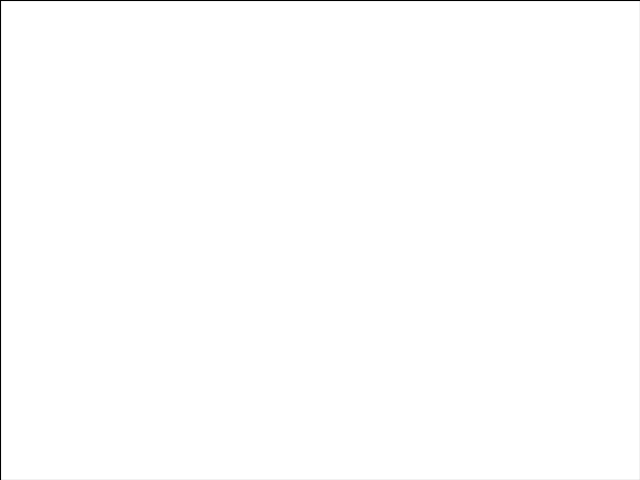

In [ ]:
misc.draw(G, coloring)

In [ ]:
rwu = RandomWarmUp1.WarmUp1Algo(G)

In [ ]:
c1 = rwu.getColoring()

rwu.addEdge(2,8)

c2 = rwu.getColoring()
misc.numberOfRecolors(c1, c2)

1

In [ ]:
rwu.getColoring()

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 3, 6: 2, 8: 1, 9: 2}

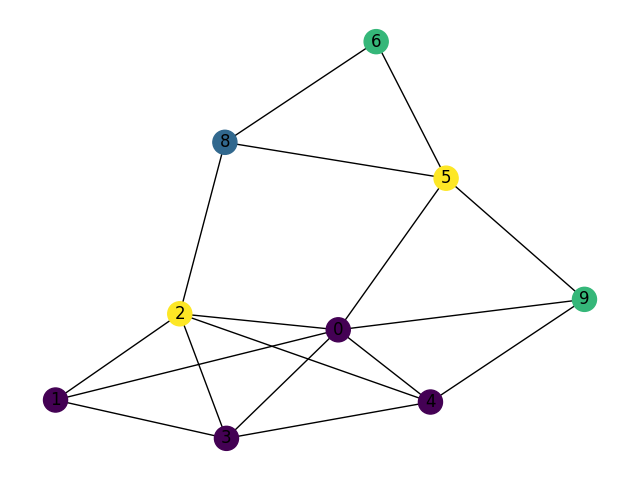

In [ ]:
misc.draw(rwu.G, rwu.getColoring())

In [ ]:
c1= rwu.getColoring()

In [ ]:
misc.numberOfRecolors(c1, c2)

NameError: name 'c2' is not defined